In [1]:
import pandas as pd
import numpy as np
#insert selected pairs
final_pairs = pd.read_excel("final_pairs.xlsx")
#import commod data
commod = pd.read_excel("commod_data.xlsx")

In [2]:
final_pairs['Leg1'][0]

'EIAEBRT'

In [3]:
commod = commod.set_index("Date")

In [4]:
#plot one cointegrated pair
stock_EIAEBRT = commod.loc["2009-01-01":"2017-12-31"][final_pairs['Leg1'][0]]
stock_OILBREN = commod.loc["2009-01-01":"2017-12-31"][final_pairs['Leg2'][0]]

In [5]:
stock_EIAEBRT = commod.loc["2009-01-01":"2017-12-31"][final_pairs['Leg1'][1]]
stock_EIAUSGJ = commod.loc["2009-01-01":"2017-12-31"][final_pairs['Leg2'][1]]

In [6]:
import matplotlib.pyplot as plt

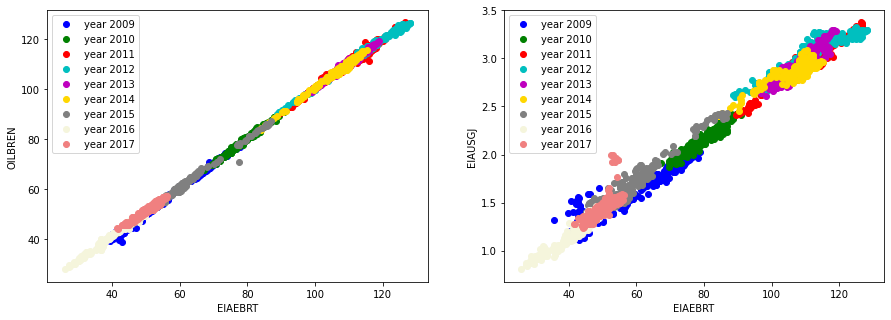

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))

ax1.set_xlabel("EIAEBRT")
ax1.set_ylabel("OILBREN")
ax1.scatter(stock_EIAEBRT[0:252],stock_OILBREN[0:252], color='b',
label = 'year 2009')
ax1.scatter(stock_EIAEBRT[252:504],stock_OILBREN[252:504], color='g',
label = 'year 2010')
ax1.scatter(stock_EIAEBRT[504:756],stock_OILBREN[504:756], color='r',
label = 'year 2011')
ax1.scatter(stock_EIAEBRT[756:1008],stock_OILBREN[756:1008], color='c',
label = 'year 2012')
ax1.scatter(stock_EIAEBRT[1008:1260],stock_OILBREN[1008:1260], color='m',
label = 'year 2013')
ax1.scatter(stock_EIAEBRT[1260:1512],stock_OILBREN[1260:1512], color='gold',
label = 'year 2014')
ax1.scatter(stock_EIAEBRT[1512:1764],stock_OILBREN[1512:1764], color='gray',
label = 'year 2015')
ax1.scatter(stock_EIAEBRT[1764:2016],stock_OILBREN[1764:2016], color='beige',
label = 'year 2016')
ax1.scatter(stock_EIAEBRT[2016:2268],stock_OILBREN[2016:2268], color='lightcoral',
label = 'year 2017')
ax1.legend()

ax2.set_xlabel("EIAEBRT")
ax2.set_ylabel("EIAUSGJ")
ax2.scatter(stock_EIAEBRT[0:252],stock_EIAUSGJ[0:252], color='b',
label = 'year 2009')
ax2.scatter(stock_EIAEBRT[252:504],stock_EIAUSGJ[252:504], color='g',
label = 'year 2010')
ax2.scatter(stock_EIAEBRT[504:756],stock_EIAUSGJ[504:756], color='r',
label = 'year 2011')
ax2.scatter(stock_EIAEBRT[756:1008],stock_EIAUSGJ[756:1008], color='c',
label = 'year 2012')
ax2.scatter(stock_EIAEBRT[1008:1260],stock_EIAUSGJ[1008:1260], color='m',
label = 'year 2013')
ax2.scatter(stock_EIAEBRT[1260:1512],stock_EIAUSGJ[1260:1512], color='gold',
label = 'year 2014')
ax2.scatter(stock_EIAEBRT[1512:1764],stock_EIAUSGJ[1512:1764], color='gray',
label = 'year 2015')
ax2.scatter(stock_EIAEBRT[1764:2016],stock_EIAUSGJ[1764:2016], color='beige',
label = 'year 2016')
ax2.scatter(stock_EIAEBRT[2016:2268],stock_EIAUSGJ[2016:2268], color='lightcoral',
label = 'year 2017')

ax2.legend()

plt.show()




In [8]:
#!pip install pykalman

In [9]:
from pykalman import KalmanFilter

In [10]:
#Kalman Filter Regression
obs_mat = np.vstack([stock_EIAEBRT,np.ones(stock_EIAEBRT.shape)]).T[:, np.newaxis]
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)

In [11]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
initial_state_mean=np.zeros(2),
initial_state_covariance=np.ones((2, 2)),
transition_matrices=np.eye(2),
observation_matrices=obs_mat,
observation_covariance=1.0,
transition_covariance=trans_cov)
state_means, state_covs = kf.filter(stock_EIAUSGJ)

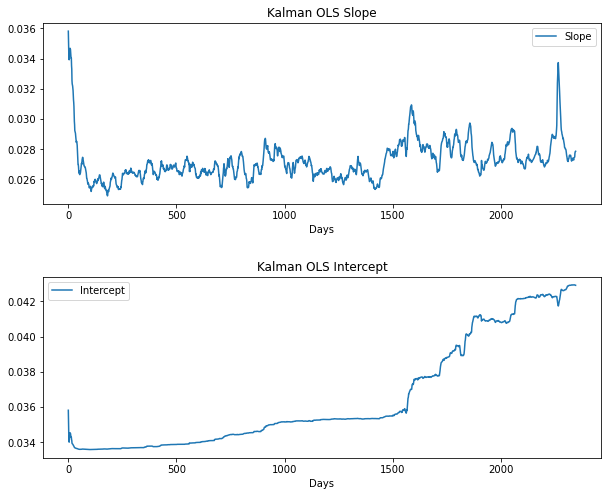

In [12]:
#plot Kalman Filter coefficient
fig, (ax1, ax2) = plt.subplots(2,1, sharex=False,figsize=(10,8))
#'plot kalman OLS coefficients: slope'
ax1.set_title('Kalman OLS Slope')
ax1.set_xlabel('Days')
ax1.plot(state_means[:,0], label = 'Slope')
ax1.legend()

'plot kalman OLS coefficients: intercept'
ax2.set_title('Kalman OLS Intercept')
ax2.set_xlabel('Days')
ax2.plot(state_means[:,1], label = 'Intercept')
ax2.legend()

plt.subplots_adjust(wspace = 1, hspace=0.4)
plt.show()


In [13]:
# a is an array of a vector of data
# t is the looking back period
def MVaverage(a, t):
    i = np.size(a)
    j = 0
    mv_t = np.zeros(i-t+1) # moving average of data interval with period t
    std_t = np.zeros(i-t+1) # std of data interval with period t
    while i>(t-1):
        mv_t[j] = np.mean(a[j:(j+t)])
        std_t[j] = np.std(a[j:(j+t)])
        j += 1
        i -= 1
    return mv_t, std_t

In [14]:
# a is an array of a vector of data
# t is the looking back period
# const is the number of std away from the moving average
def BBand(a, t, const):
    BollingerBand = []
    mv, std = MVaverage(a, t)
    LowerBand = np.subtract(mv, const*std)
    UpperBand = np.add(mv, const*std)
    BollingerBand.append([LowerBand, UpperBand])
    return mv, BollingerBand

In [15]:
# ret_cum also can be portfolio position series
def MaxDrawdown(Ret_Cum):
    ContVal = np.zeros(np.size(Ret_Cum))
    MaxDD = np.zeros(np.size(Ret_Cum))
    for i in range(np.size(Ret_Cum)):
        if i == 0:
            if Ret_Cum[i] < 0:
                ContVal[i] = Ret_Cum[i]
            else:
                ContVal[i] = 0
        else:
            ContVal[i] = Ret_Cum[i] - np.max(Ret_Cum[0:(i+1)])
        MaxDD[i] = np.min(ContVal[0:(i+1)])
    return MaxDD

In [16]:
import statsmodels.api as sm

In [17]:
# a is an array of a vector of data
# t is the looking back period
# const is the number of std away from the moving average
# stop_loss: amount of loss we take (eg. 0.2*capital)
# KalmanFilter: True or False, whether use Kalman Filter, default is False
def BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF):
    if KF==True:
        obs_mat = np.vstack([stock_2,np.ones(stock_2.shape)]).T[:, np.newaxis]
        delta = 1e-5
        trans_cov = delta / (1 - delta) * np.eye(2)
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                          initial_state_mean=np.zeros(2),
                          initial_state_covariance=np.ones((2, 2)),
                          transition_matrices=np.eye(2),
                          observation_matrices=obs_mat,
                          observation_covariance=1.0,
                          transition_covariance=trans_cov)
        state_means, state_covs = kf.filter(stock_1)
        'generate spread based on kalman OLS'
        spread_k = np.zeros(np.size(stock_1))
        for i in range(np.size(spread_k)):
            spread_k[i] = stock_1[i] - state_means[i,0]*stock_2[i] - state_means[i,1]
        a = pd.Series(spread_k)
    else:
        results = sm.OLS(stock_1, stock_2).fit()
        predict = results.predict(stock_2)
        a = np.subtract(stock_1, predict)
        
    mv, BB = BBand(a, t, const) # moving average and bollinger band
    m = np.size(mv)
    Entry = np.zeros(m-1) # entry signal
    Holding = np.zeros(m) # holding state
    PL_Holding = np.zeros(m-1) # holding return
    PL_Cum = np.zeros(m-1) # cumulative return of trading strategy
       
    'produce entry signal'
    for i in range(m-1):
        if i == 0:
            if a[i+t]<BB[0][0][i+1] and a[i+t-1]>BB[0][0][i]:
                Entry[i] = 1
            else:
                Entry[i] = 0
        else:
            if a[i+t]<BB[0][0][i+1] and a[i+t-1]>BB[0][0][i]:
                Entry[i] = 1
            else:
                if a[i+t]>BB[0][0][i+1] and a[i+t-1]<BB[0][0][i]:
                    Entry[i] = -1
                else:
                    Entry[i] = 0
    'holding decision'
    for i in range(1,m,1):
        if Entry[i-1]==0:
            Holding[i] = Holding[i-1]
        else:
            if Entry[i-1] + Holding[i-1] == 0:
                Holding[i]=0
            else:
                if np.abs(Entry[i-1]+Holding[i-1])==1:
                    Holding[i] = Entry[i-1] + Holding[i-1]
                else:
                    Holding[i] = Holding[i-1]

    PL_Holding = np.multiply(Holding[1:], a[(t):])*(-1) * (capital/stock_1[t])
    PL_Holding.index = range(np.size(PL_Holding))
    commission = Entry * (4.95 + 0.0001 * capital)*2
    PL_Holding = PL_Holding - commission
    
    'Calculate cumulative P/L'
    for i in range(np.size(PL_Holding)):
        if i ==0:
            PL_Cum[i] = PL_Holding[0]
        else:
            PL_Cum[i] = PL_Cum[i-1] + PL_Holding[i]
    if np.min(PL_Cum) < (-stop_loss * capital):
        po = np.min(np.where(PL_Cum < (-stop_loss*capital)))
        PL_Cum[po:] = PL_Cum[po]
        
    po = np.where(PL_Cum < (stop_loss*capital))
        
    'calculate maximum drawdown'
    MaxDD = MaxDrawdown(PL_Cum)
    results = []
    results.append([a, Entry, Holding, PL_Holding, PL_Cum, MaxDD])
    return results



In [18]:
def Portfolio(capital, clustered_series, significance, coint_start_day,
              coint_end_day, t, const, stop_loss, rolling_days, KF, E_selection):
    end_day_index = Price.index.get_loc(coint_end_day)
    num = np.size(Price.index)
    
    PL_daily_portfolio = []
    PL_cum_portfolio = []
    
    while(end_day_index < num):
        Opt_pairs = PairSelection(clustered_series, significance,
                              coint_start_day, coint_end_day, E_selection)
        num_pairs = len(Opt_pairs) # count pairs
        # start date of testing period
        start_day = Price.index[end_day_index -t]
        if (end_day_index + rolling_days) < num:
            end_day = Price.index[end_day_index + rolling_days] # rolling day is 126
        else:
            end_day = Price.index[num-1]
        
        PL_daily_ContVal = [] # save each pair's daily P/L
        
        for i in range(num_pairs):
            stock_1 = Price.loc[start_day:end_day, Opt_pairs[i][0]]
            stock_2 = Price.loc[start_day:end_day:, Opt_pairs[i][1]]
            each_pair = BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF)
            PL_daily_ContVal.append(each_pair[0][3])
        
        PL_daily_portfolio.append(np.sum(PL_daily_ContVal, axis=0))

        coint_start_day = Price.index[Price.index.get_loc(coint_start_day) + rolling_days]
        coint_end_day_index = Price.index.get_loc(coint_end_day) +rolling_days
        if coint_end_day_index < num:
            coint_end_day = Price.index[coint_end_day_index]
            end_day_index = coint_end_day_index
        else:
            end_day_index = coint_end_day_index
            
        PL_daily_portfolio = list(itertools.chain.from_iterable(PL_daily_portfolio))
        PL_cum_portfolio = np.zeros(np.size(PL_daily_portfolio))
        for i in range(np.size(PL_daily_portfolio)):
            if i==0:
                PL_cum_portfolio[i] = PL_daily_portfolio[i]
            else:
                PL_cum_portfolio[i] = PL_cum_portfolio[i-1] + PL_daily_portfolio[i]
        
        maxdd_portfolio = MaxDrawdown(PL_cum_portfolio)
        
        return PL_daily_portfolio, PL_cum_portfolio, maxdd_portfolio, num_pairs

In [19]:

stock_EIAEBRT = commod.loc["2009-01-01":"2017-12-31"][final_pairs['Leg1'][7]]
stock_OILBREN = commod.loc["2009-01-01":"2017-12-31"][final_pairs['Leg2'][7]]
t = 150
const = 0.1
stop_loss = 0
capital = 1000000
test_pair_T = BBTrading(capital, stock_EIAEBRT, stock_OILBREN, t, const, stop_loss, KF=True)
test_pair_F = BBTrading(capital, stock_EIAEBRT, stock_OILBREN, t, const, stop_loss, KF=False)


In [20]:
test_pair_F[0][4]

array([   -0.        ,    -0.        ,    -0.        , ...,
       -4983.53987143, -4983.53987143, -4983.53987143])

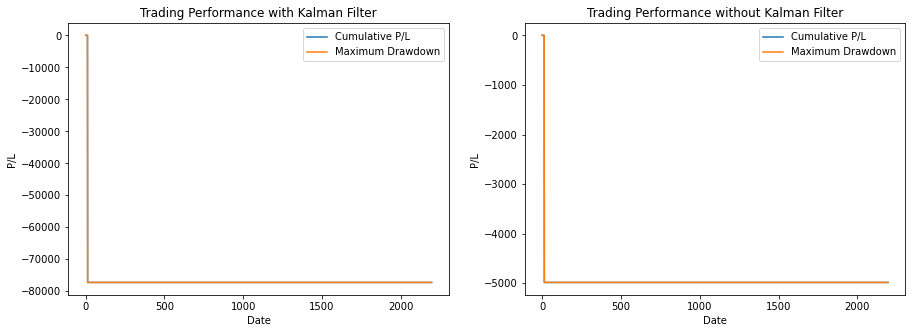

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))
ax1.set_title("Trading Performance with Kalman Filter")
ax1.set_xlabel("Date")
ax1.set_ylabel("P/L")
ax1.plot(test_pair_T[0][4], label="Cumulative P/L")
ax1.plot(test_pair_T[0][5], label="Maximum Drawdown")
ax1.legend()
ax2.set_title("Trading Performance without Kalman Filter")
ax2.set_xlabel("Date")
ax2.set_ylabel("P/L")
ax2.plot(test_pair_F[0][4], label="Cumulative P/L")
ax2.plot(test_pair_F[0][5], label="Maximum Drawdown")
ax2.legend()
plt.show()